In [1]:
import numpy as np
import pandas as pd
import os, sys
import matplotlib.pyplot as plt
import email
import email.policy
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import random

In [2]:
ham_filenames = [name for name in sorted(os.listdir(r'D:\Program Files\New folder\hamnspam\ham')) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir(r'D:\Program Files\New folder\hamnspam\spam')) if len(name) > 20]

In [3]:
def load_email(is_spam, filename):
    directory = r'D:\Program Files\New folder\hamnspam\spam' if is_spam else r'D:\Program Files\New folder\hamnspam\ham'
    with open(os.path.join(directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

ham_emails = [load_email(is_spam=False, filename=name) for name in ham_filenames]
spam_emails = [load_email(is_spam=True, filename=name) for name in spam_filenames]

## Tokenising Mails

In [4]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import string
import re

In [5]:
stop_words = (stopwords.words('english'))
punc = list(string.punctuation)

stop_words += punc
stop_words += ['-', 'http', 'yahoo', 'google', '_']

In [6]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

lemmatizer = WordNetLemmatizer()

In [7]:
def simple_pos_tag(tag):
    if(tag.startswith('J')):
        return wordnet.ADJ
    elif(tag.startswith('V')):
        return wordnet.VERB
    elif(tag.startswith('N')):
        return wordnet.NOUN
    elif(tag.startswith('R')):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [8]:
def tokenise(words):
    clean_words = []
    word = word_tokenize(words.lower())
    
    for s in word:
        if len(s) <=2 or s in stop_words or not(s.isalpha()):
            continue
        clean_words.append(s)

    l_words = [lemmatizer.lemmatize(w, simple_pos_tag(w)) for w in clean_words]
    return l_words

In [9]:
def html_to_plain(mail):
    mail = mail.get_content()
    return BeautifulSoup(mail, 'html.parser').text.replace('\n\n', '')

In [10]:
def email_to_plain(email):
    mail_content_type = email.get_content_type()
    content = ''

    if mail_content_type == 'text/plain':
        content = (email.get_content().replace('-', ''))
    elif mail_content_type == 'text/html':
        content = (html_to_plain(email).replace('-', ''))
    
    content = re.sub(r'http\S+', '', content)
    return tokenise(content)

In [11]:
all_mails = []

In [12]:
for mail in ham_emails:
    all_mails.append((email_to_plain(mail), 'ham'))

In [13]:
for mail in spam_emails:
    try:
        mail.get_content()
    except LookupError:
        continue
    all_mails.append((email_to_plain(mail), 'spam'))

In [14]:
random.shuffle(all_mails)

## Visulising Data

In [15]:
all_words = []
for doc, cat in all_mails:
    all_words += doc

In [16]:
dict_words = {}
for w in all_words:
    if w in dict_words:
        dict_words[w] +=1
    else:
        dict_words[w] = 1
        
sorted_dict = sorted(dict_words.items(), key=lambda x:x[1], reverse=True)
print(len(sorted_dict))

24553


In [17]:
x = np.arange(1, len(sorted_dict)+1)
x_ = (np.ones(len(sorted_dict)))*3000
y = []
for i in range(len(sorted_dict)):
    y.append(sorted_dict[i][1])

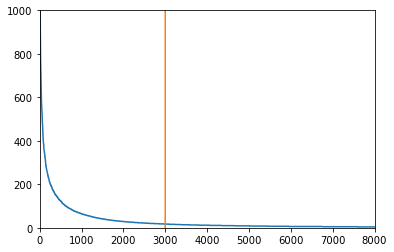

In [18]:
import matplotlib.pyplot as plt

plt.plot(x, y)
plt.plot(x_,x)
plt.axis([0,8000,0,1000])
plt.show()

## Model Creation

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
X = [" ".join(doc) for doc, catagory in all_mails]

y = [catagory for doc, catagory in all_mails]

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [22]:
len(X_train), len(X_test)

(2213, 738)

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

count_vec = CountVectorizer(max_features = 3000)

In [24]:
X_train_set = count_vec.fit_transform(X_train)
X_test_set = count_vec.transform(X_test)

In [25]:
X_train_set.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [26]:
# print(count_vec.get_feature_names())

In [27]:
count_vec.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 3000,
 'min_df': 1,
 'ngram_range': (1, 1),
 'preprocessor': None,
 'stop_words': None,
 'strip_accents': None,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'vocabulary': None}

### Naive Bayes

In [28]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [29]:
classifier = BernoulliNB()

classifier.fit(X_train_set, y_train)

BernoulliNB()

In [30]:
print("Training Score: ", classifier.score(X_train_set, y_train))
print("Testing Score: ", classifier.score(X_test_set, y_test))

Training Score:  0.9435155896972436
Testing Score:  0.9349593495934959


In [31]:
y_pred = classifier.predict(X_test_set)

confusion_matrix(y_test, y_pred)

array([[622,  26],
       [ 22,  68]], dtype=int64)

In [32]:
# classifier.predict()

mail = [ham_emails[11].get_content()]
mail = 'you win 10 dollers'

mail = count_vec.transform(mail)
classifier.predict(mail)

array(['ham'], dtype='<U4')